In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Tomato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE

)

Found 16011 files belonging to 10 classes.


In [7]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

32


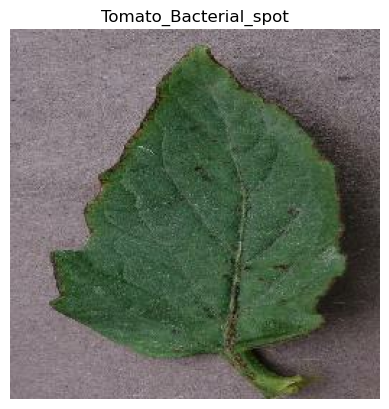

In [13]:
for image_batch,labels_batch in dataset.take(1):
    print(len(image_batch))
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[0]])
    plt.axis("off")

In [11]:
len(dataset)

501

In [15]:
32 * 501

16032

In [16]:
train_size = 0.8
test_size = 0.1
validation_size = 0.1


In [17]:
def get_dataset_partition_tf(ds, train_split = 0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 100000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split * ds_size)
    test_size = int(test_split * ds_size)
    val_size = int(val_split * ds_size)
    #Take the first part of the dataset for training
    train_ds = ds.take(train_size)
    #Balance dataset which are not present in training dataset
    balance_ds = ds.skip(train_size)
    #From the balance dataset take the first part for validation
    val_ds = balance_ds.take(val_size)
    test_ds = balance_ds.skip(test_size)
    return train_ds,val_ds,test_ds
    

In [18]:
train_ds,val_ds,test_ds = get_dataset_partition_tf(dataset)

In [19]:
len(train_ds)

400

#### Perform cache and prefetch

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.3),
])

### Model Building

In [25]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
#     Flatten
    layers.Flatten(),
    
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')

])

In [26]:
model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [28]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
model_history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10

)

Epoch 1/10


400/400 [==============================] - 301s 736ms/step - loss: 1.3752 - accuracy: 0.5129 - val_loss: 1.1780 - val_accuracy: 0.5831
Epoch 2/10
400/400 [==============================] - 286s 714ms/step - loss: 0.6866 - accuracy: 0.7584 - val_loss: 0.8075 - val_accuracy: 0.7256
Epoch 3/10
400/400 [==============================] - 349s 874ms/step - loss: 0.5096 - accuracy: 0.8210 - val_loss: 0.8419 - val_accuracy: 0.7381
Epoch 4/10
400/400 [==============================] - 333s 832ms/step - loss: 0.4218 - accuracy: 0.8542 - val_loss: 0.8579 - val_accuracy: 0.7513
Epoch 5/10
400/400 [==============================] - 321s 803ms/step - loss: 0.3726 - accuracy: 0.8685 - val_loss: 0.6393 - val_accuracy: 0.7906
Epoch 6/10
400/400 [==============================] - 332s 830ms/step - loss: 0.3341 - accuracy: 0.8836 - val_loss: 0.5279 - val_accuracy: 0.8225
Epoch 7/10
400/400 [==============================] - 318s 795ms/step - loss: 0.3097 - accuracy: 0.8891 - val_loss: 0.8126

In [32]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 31s 192ms/step - loss: 0.3796 - accuracy: 0.8750


In [33]:
model_history.params

{'verbose': 1, 'epochs': 10, 'steps': 400}

In [35]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [39]:
accuracy = model_history.history['accuracy']
loss = model_history.history['loss']

validation_accuracy = model_history.history['val_accuracy']
validation_loss = model_history.history['val_loss']

Text(0.5, 1.0, 'Accuracy')

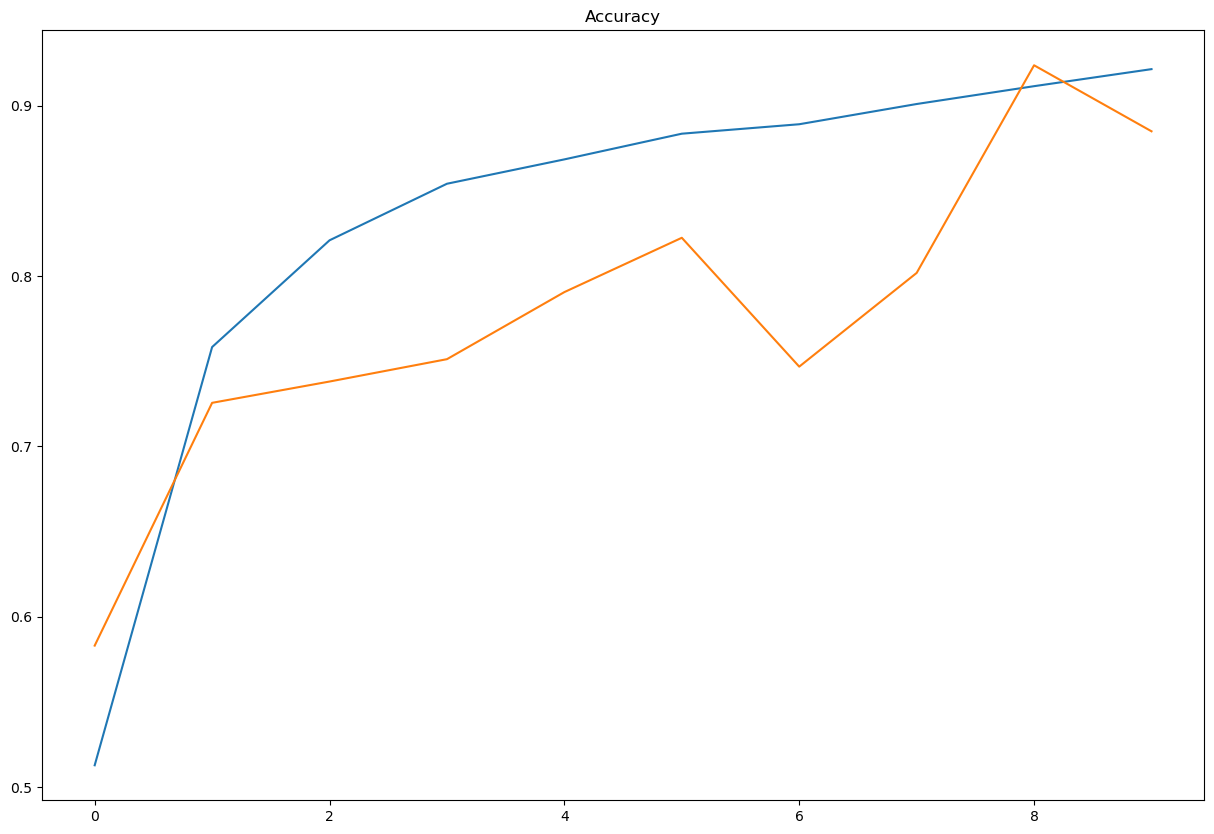

In [41]:
plt.figure(figsize=(15,10))
plt.plot(range(10),accuracy, label='Training Accuracy')
plt.plot(range(10),validation_accuracy,label='Validation Accuracy')
plt.title('Accuracy')

In [42]:
import numpy as np

first image to predict
actual label: Tomato__Target_Spot
1/1 [==============================] - 1s 967ms/step
Predicted ans Tomato__Target_Spot


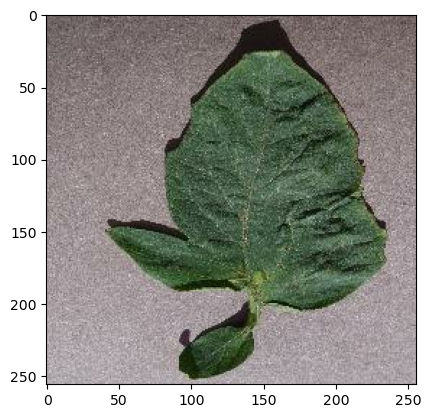

In [45]:
for image_batch,labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_image_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_image_label])
    
    batch_predictions = model.predict(image_batch)
    
    pred_ans = np.argmax(batch_predictions[0])
    
    print("Predicted ans", class_names[pred_ans])
    

In [51]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    
    return predicted_class

1/1 [==============================] - 0s 31ms/step


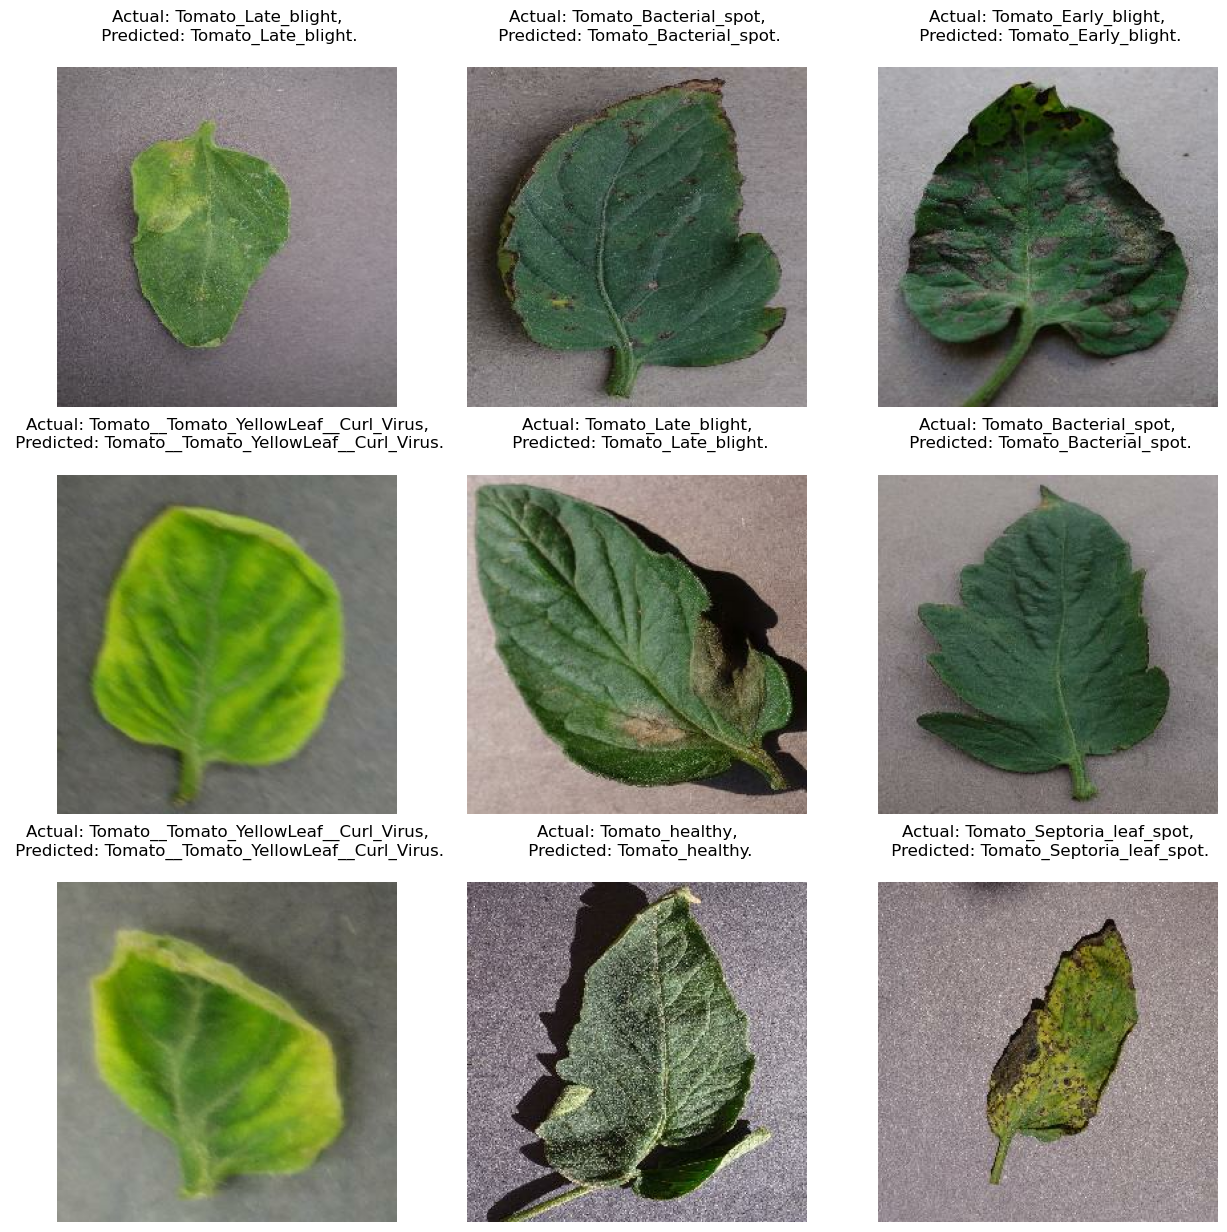

In [54]:
plt.figure(figsize=(15, 15))

for images , labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class = predict(model,images[i].numpy())
        
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n ")
        
        plt.axis("off")

In [56]:
model_version = 1
model.save(f"../models/Tom{model_version}")

INFO:tensorflow:Assets written to: ../models/Tom1\assets


INFO:tensorflow:Assets written to: ../models/Tom1\assets
